In [1]:
# %%capture
# This cell will take time
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2024.12.4
Uninstalling unsloth-2024.12.4:
  Successfully uninstalled unsloth-2024.12.4
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-8typvign/unsloth_6f6d6e10ca13466284ecffe8dba24e7a
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-8typvign/unsloth_6f6d6e10ca13466284ecffe8dba24e7a
  Resolved https://github.com/unslothai/unsloth.git to commit df808d074d307d396b8c04640ef51375d68f2ef0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.12.4-py3-none-any.whl size=173562 sha256=697f8c6e6aae1bde88cd4dddaacfee6074f6dcc3a9ba5c43e8e5f686967e8f92
  Stored in directory: /tmp/pip-ephem-wheel-cache-utgwh3v1/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth


In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 256 # Choose any
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
# load data
import pandas as pd
from datasets import Dataset

dataset = pd.read_csv('cnames_sampled.csv')
dataset = Dataset.from_pandas(dataset)
len(dataset)

19539

In [6]:
# split tain and test 8:2

dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['domain', 'rule', 'fingerprint', 'original', 'resolved'],
        num_rows: 15631
    })
    test: Dataset({
        features: ['domain', 'rule', 'fingerprint', 'original', 'resolved'],
        num_rows: 3908
    })
})

In [7]:
# format data

prompt = """Identify if the domain and rule if it related to fingerprinting.

### Domain:
{}

### Rule:
{}

### Explainaition

### Is Tracking:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    domain = examples["domain"]
    rule       = examples["rule"]
    label      = examples["fingerprint"]
    texts = []
    for domain, rule, label in zip(domain, rule, label):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(domain, rule, label) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [8]:
train_dataset = dataset['train'].map(formatting_prompts_func, batched = True,)
print(train_dataset['text'][0])

Map:   0%|          | 0/15631 [00:00<?, ? examples/s]

Identify if the domain and rule if it related to fingerprinting.

### Domain:
cloudflare.net

### Rule:
cloudflare\.net\/css\/colors\.css

### Explainaition

### Is Tracking:
0<|end_of_text|>


In [9]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 8,
        warmup_steps = 100,
        num_train_epochs = 1,
        max_steps = -1,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 50,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    )

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 4,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args
)

Map (num_proc=4):   0%|          | 0/15631 [00:00<?, ? examples/s]

In [10]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 15,631 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 8
\        /    Total batch size = 64 | Total steps = 244
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
50,3.835500
100,2.027600
150,1.588900
200,1.521500


# Test

In [11]:
from transformers import TextGenerationPipeline

class MyPipeline(TextGenerationPipeline):
    def postprocess(pipeline ,dict):
      # dict_keys(['generated_sequence', 'input_ids', 'prompt_text'])
      tmp = dict['generated_sequence']
      holder = len(dict['input_ids'][0])
      tmp2 = tokenizer.batch_decode([tmp[0][0][holder:]], skip_special_tokens=True)
      return tmp2[0]

FastLanguageModel.for_inference(model)
pipe = MyPipeline(
    task="text-generation",
    model = model,
    tokenizer = tokenizer,
    batch_size = 4,
    eos_token_id = model.config.eos_token_id,
    max_new_tokens = 64
)


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

In [12]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    domain = examples["domain"]
    rule       = examples["rule"]
    texts = []
    for domain, rule in zip(domain, rule):
        text = prompt.format(domain, rule, "", "")
        texts.append(text)
    return { "text" : texts, }

train_dataset = dataset['test'].map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/3908 [00:00<?, ? examples/s]

In [13]:

test_input = train_dataset['text']
test_key = train_dataset['fingerprint']

In [18]:

res = []

for i in range(10):
  # sperate into 10 runs
  l = 100*i
  r = 100*(i+1)
  print(l, r)
  res += pipe(test_input[l:r])


0 100
100 200
200 300
300 400
400 500
500 600
600 700


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


700 800
800 900
900 1000


In [ ]:

res_tmp = []

for i,v in enumerate(res):
  tf = v.strip().split('\n')[-1]
  if tf == '1':
    res_tmp.append(True)
  else:
    res_tmp.append(False)

correct = 0
incorrect = 0
for i in range(len(res_tmp)):
  if test_key[i] == res_tmp[i]:
    correct += 1
  elif test_key[i] != res_tmp[i]:
    incorrect += 1
  else:
    print(i)

ac = correct/len(res_tmp)

In [22]:
ac = correct/len(res_tmp)
print(f'Accuarcy:{ac*100}%')

Accuarcy:84.3%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       848
           1       0.32      0.06      0.10       118
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10

    accuracy                           0.84      1000
   macro avg       0.29      0.26      0.25      1000
weighted avg       0.76      0.84      0.79      1000



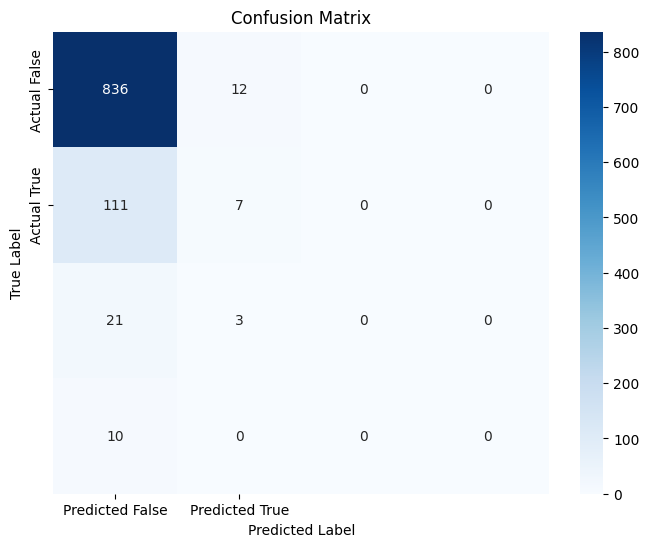

Precision: 0.7624
Recall: 0.8430
F1-score: 0.7883


In [23]:
# create confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the classification report
report = classification_report(test_key[:len(res_tmp)], res_tmp, output_dict=True)
print(classification_report(test_key[:len(res_tmp)], res_tmp))

# Create a confusion matrix
cm = confusion_matrix(test_key[:len(res_tmp)], res_tmp)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted False", "Predicted True"],
            yticklabels=["Actual False", "Actual True"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Access specific metrics from the classification report
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
